In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
BASE_PATH = '/content/drive/Shared drives/Citadel Datathon 2020 Summer/datasets'
UK_INFLATION_CSV = 'UK_inflation.csv'
UK_HOUSE_PRICE_CSV = 'UK_house_price.csv'
UK_HOUSE_SALES_VOLUME_CSV = 'UK_house_sales_volume.csv'

# 1.Read Data

In [4]:
london_inflation = pd.read_csv(os.path.join(BASE_PATH, UK_INFLATION_CSV))

In [5]:
price = pd.read_csv(os.path.join(BASE_PATH, UK_HOUSE_PRICE_CSV))
vol = pd.read_csv(os.path.join(BASE_PATH, UK_HOUSE_SALES_VOLUME_CSV))

In [6]:
price.index = pd.to_datetime(price['Unnamed: 0'])
price = price.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 34',  'Unnamed: 37',  'Unnamed: 47'])

In [7]:
vol.index = pd.to_datetime(vol['Unnamed: 0.1'])
vol = vol.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 34',  'Unnamed: 37',  'Unnamed: 47'])
vol = vol.iloc[1:, :]
vol = vol.astype(int)

In [8]:
price.columns

Index(['City of London', 'Barking & Dagenham', 'Barnet', 'Bexley', 'Brent',
       'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich',
       'Hackney', 'Hammersmith & Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington & Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster',
       'Inner London', 'Outer London', 'NORTH EAST', 'NORTH WEST',
       'YORKS & THE HUMBER', 'EAST MIDLANDS', 'WEST MIDLANDS',
       'EAST OF ENGLAND', 'LONDON', 'SOUTH EAST', 'SOUTH WEST', 'England'],
      dtype='object')

# 2.Preprocessing

In [9]:
# set host and London boroughs
host_boroughs = ['Barking & Dagenham', 'Greenwich', 'Hackney', 'Newham', 'Tower Hamlets', 'Waltham Forest']
london_boroughs = price.columns[:33]
other_place_with_venue = ['NORTH EAST', 'NORTH WEST', 'EAST OF ENGLAND', 'SOUTH EAST']

In [10]:
# change price shape
price_unstack = pd.DataFrame(price.unstack()).reset_index()
price_unstack.columns = ['area', 'date', 'price']
price_unstack = price_unstack[price_unstack['area'].isin(london_boroughs)]

In [11]:
def before_after(x):
    """determine if before or after announce"""
    if x < pd.to_datetime('2005-07-06'):
        return 0
    return 1

In [12]:
# add dummy variables
price_unstack['before_after'] = price_unstack['date'].apply(before_after)
price_unstack['if_host'] = price_unstack['area'].isin(host_boroughs) * 1
price_unstack['if_host x before_after'] = price_unstack['if_host'] * price_unstack['before_after']

In [13]:
# multiply by inflation
price_unstack['year'] = price_unstack['date'].dt.year
price_unstack = price_unstack.merge(london_inflation[['year', 'multiplier']], on='year', how='left')
price_unstack.dropna(inplace=True)
price_unstack['price_inflated'] = price_unstack['price'] * price_unstack['multiplier']

In [14]:
# add time period stamps
price_unstack['<2005'] = (price_unstack['year'] < 2005) * 1
price_unstack['2005-2012'] = price_unstack['year'].isin(range(2005, 2012)) * 1
price_unstack['>2012'] = (price_unstack['year'] > 2012) * 1
# add more interactions
price_unstack['<2005 x if_host'] = price_unstack['<2005'] * price_unstack['if_host']
price_unstack['2005-2012 x if_host'] = price_unstack['2005-2012'] * price_unstack['if_host']
price_unstack['>2012 x if_host'] = price_unstack['>2012'] * price_unstack['if_host']

# 3.BoxCox

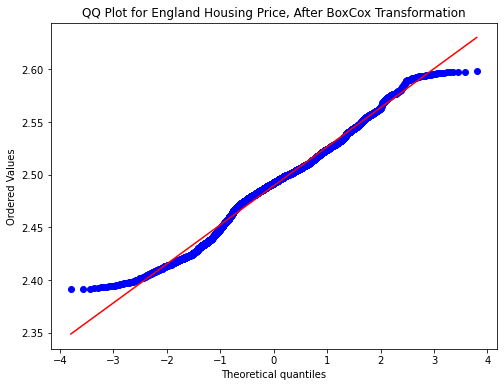

In [25]:
# convert to gaussian dist
y, _ = stats.boxcox(price_unstack['price_inflated'])
y = np.log(y)
price_unstack['y'] = y
# check with qq plot
fig, ax = plt.subplots(figsize=(8, 6))
prob = stats.probplot(y, dist=stats.norm, plot=ax)
plt.title('QQ Plot for England Housing Price, After BoxCox Transformation')
plt.savefig('QQ Plot for England Housing Price, After BoxCox Transformation.png')
plt.show()

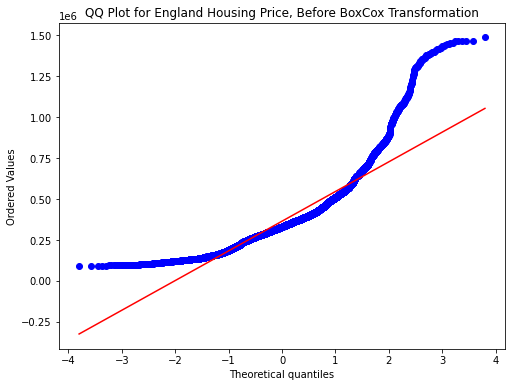

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
prob = stats.probplot(price_unstack['price_inflated'], dist=stats.norm, plot=ax)
plt.title('QQ Plot for England Housing Price, Before BoxCox Transformation')
plt.savefig('QQ Plot for England Housing Price, Before BoxCox Transformation.png')
plt.show()

# 4.Hedonic Model

## 4.1Logged Price

In [ ]:
X = price_unstack[['before_after', 'if_host', 'if_host x before_after']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     2275.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        05:34:28   Log-Likelihood:                 20364.
No. Observations:                9504   AIC:                        -4.072e+04
Df Residuals:                    9500   BIC:                        -4.069e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0439      0.001     67.606      0.0

## 4.2Pct Change

In [ ]:
X = price_unstack[['before_after', 'if_host', 'if_host x before_after']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(price_unstack['price_inflated'].pct_change()[1:].values, X[1:, ]).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.01461
Date:                Thu, 16 Jul 2020   Prob (F-statistic):              0.998
Time:                        05:24:16   Log-Likelihood:                 15875.
No. Observations:                9503   AIC:                        -3.174e+04
Df Residuals:                    9499   BIC:                        -3.171e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          6.562e-05      0.001      0.063      0.9

## 4.3With Time Stamp

In [ ]:
X = price_unstack[['<2005', '2005-2012', '>2012', 'if_host', '<2005 x if_host', '2005-2012 x if_host', '>2012 x if_host']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     1175.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        06:07:28   Log-Likelihood:                 20757.
No. Observations:                9504   AIC:                        -4.150e+04
Df Residuals:                    9496   BIC:                        -4.144e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0381      0.002    -23.994      0.0